## 处理序列数据的神经网络

In [3]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 64
TIME_STEP = 28      # rnn 时间步数 / 图片高度
INPUT_SIZE = 28     # rnn 每步输入值 / 图片每行像素
LR = 0.01           # learning rate
DOWNLOAD_MNIST = True  # 如果你已经下载好了mnist数据就写上 Fasle


# Mnist 手写数字
train_data = dsets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)

100.1%

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


torch.Size([60000, 28, 28])
torch.Size([60000])


/Users/cristalyin/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/cristalyin/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Text(0.5, 1.0, '5')

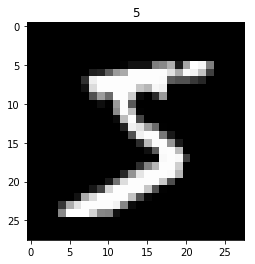

In [4]:
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])


In [6]:
# data loder for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle = True)
# convert test data into Variable, pick 2000 samples to speed upi testing

test_data = dsets.MNIST(root='./mnist/', train=False, transform = transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.
test_y = test_data.test_labels.numpy()[:2000]


/Users/cristalyin/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/cristalyin/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size = 28,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True,
        )
        
        self.out = nn.Linear(64, 10)  # 输出层
    def forward(self, x):
        
        r_out, (h_n, h_c) = self.rnn(x, None)
        
        
        out = self.out(r_out[:, -1, :])
        return out
rnn = RNN()
print(rnn)


RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [9]:
#训练
optimizer = torch.optim.Adam(rnn.parameters(), lr = LR)
loss_func = nn.CrossEntropyLoss()
for epoch in range(EPOCH):
    for step, (x, b_y) in enumerate(train_loader):
        b_x = x.view(-1, 28, 28)
        
        output = rnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 0.1135 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0849 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0485 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1850 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1565 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0763 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1965 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2542 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0544 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1287 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0523 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0350 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1218 | test accuracy: 0.96
Epoch:  0 | train loss: 0.3913 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2698 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0831 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0422 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0383 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1472 | test accuracy

In [11]:
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10],'real number')

[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
